In [43]:
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import math

np.random.seed(421)

## question 1

In [36]:
def objective_function(x, A, b, lambda_):
    term1 = 0.5 * np.linalg.norm((A @ x) - b)**2
    term2 = lambda_ * np.linalg.norm(x, ord=1)
    return term1 + term2

def soft_thresholding_operator(x, threshold):
    # print(np.abs(x))
    # print(np.abs(x) - threshold)
    # print(np.maximum(np.abs(x) - threshold, 0))
    # input()
    return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)

In [42]:
def ISTA(A, b, x, lambda_):
    objValue = []
    eigenvalues = np.linalg.eigvals(A.T @ A)

    # Find the largest eigenvalue
    L = np.max(np.real(eigenvalues))
    print("L", L)
    k = 0
    while(1):
        # print(k)
        # print(x - ((1/L) * A.T @ (A @ x - b)))
        x_new = soft_thresholding_operator(x - ((1/L) * (A.T @ (A @ x - b))), lambda_ / L)
        # print("delta x", np.linalg.norm(x_new - x))
        # print(np.abs(objective_function(x_new, A, b)))
        if(np.linalg.norm(x_new - x) < 1e-9):
            break
        objValue.append(objective_function(x, A, b, lambda_))
        x = x_new
        k+=1
    return x, objValue

# Create random matrix A
A = np.array([[47, -15, -4, -16, -23, -13, -36, 6],
              [-12, -28, 28, 14, -23, 4, 17, -12],
              [15, -28, 6, 17, 2, -2, -18, 10],
              [-4, 10, 4, -5, 14, -39, 2, 15],
              [18, -4, 32, 4, 52, -9, -11, 34]])

b = np.array([[119],
              [-46],
              [51],
              [-8],
              [40]])

x = np.ones((A.shape[1], 1))

L 6898.065876561629
L 6898.065876561629
L 6898.065876561629


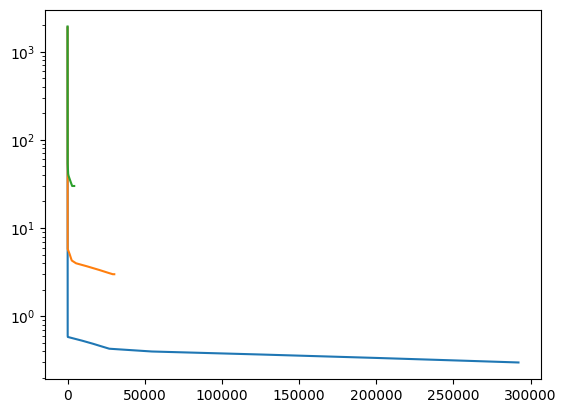

finX [[ 1.00010952]
 [-0.        ]
 [-0.        ]
 [-0.        ]
 [ 0.        ]
 [-0.        ]
 [-1.99982312]
 [ 0.        ]]
finX [[ 1.00109453]
 [-0.        ]
 [-0.        ]
 [-0.        ]
 [ 0.        ]
 [-0.        ]
 [-1.99823194]
 [ 0.        ]]
finX [[ 1.01094467]
 [-0.        ]
 [-0.        ]
 [-0.        ]
 [ 0.        ]
 [-0.        ]
 [-1.98232017]
 [ 0.        ]]


In [41]:
finX01, objValues01= ISTA(A, b, x, 0.1)
finX1, objValues1= ISTA(A, b, x, 1)
finX10, objValues10= ISTA(A, b, x, 10)

plt.plot(range(len(objValues01) - 1), objValues01[1:])
plt.plot(range(len(objValues1) - 1), objValues1[1:])
plt.plot(range(len(objValues10) - 1), objValues10[1:])
plt.yscale('log')
plt.show()
print("finX", finX01)
print("finX", finX1)
print("finX", finX10)

## question 3

In [63]:
import numpy as np

import matplotlib.pyplot as plt
import math
def foo(x):
    return 10 * ((x[1] - (x[0] ** 2)) ** 2) + (2 - x[0]) ** 2 + (4 - x[1]) ** 2

def fooGradient(x):
    return np.array([40 * (x[0] ** 2 - x[1]) * x[0] + 2 * x[0] - 4, 20 * (x[1] - x[0] ** 2) -8 + 2 * x[1]])

def armijo(x, alpha, direction, c, gradX):
    f1 = foo(x)
    f2 = foo(x + alpha * direction)
    imp = c * alpha * gradX.T @ direction
    # print("x=", x, "f1=", f1, "f2=", f2, "imp=", imp, "alpha=", alpha, "direction=", direction)
    return f2 <= f1 + imp

def happy(gradSquareX):
    return gradSquareX < 1e-5

#### DFP

In [87]:
#### DFP
def DFPHessian(h, p, q):
    p = p.reshape(2, 1)
    q = q.reshape(2, 1)
    # print("DFPHessian", h @ q, h @ q @ q.T)
    return np.array(h + ((p @ p.T) / (p.T @ q)) - ((h @ q) @ q.T @ h) / ((q.T @ h) @ q))

def DFP():
    c = 0.5
    rho = 0.5
    alpha_0 = 1
    h = np.array([[1, 0], [0, 1]])
    x = np.array([0, 0])
    k = 1
    fooValues = []
    gradValues = []
    while True:
        fooValue = foo(x)
        # print(f"\rk={k}, foo={fooValue}, x={x}", end="")
        alpha = alpha_0
        fooValues.append(fooValue)
        gradX = fooGradient(x)
        gradSquareX = gradX.T @ gradX
        gradValues.append(gradSquareX)
        if happy(gradSquareX):
            break

        direction = -h @ gradX
        while not armijo(x, alpha, direction, c, gradX):
            alpha = alpha * rho
        # next step
        p = alpha * direction
        x = x + alpha * direction
        q = fooGradient(x) - gradX
        k = k + 1
        h = DFPHessian(h, p, q)
        print(k, x, p, q, h, alpha, gradX, direction)

    print()
    print("k=", k)
    print("x=", x)
    return fooValue
temp = DFP()

2 [2. 4.] [2. 4.] [4. 8.] [[ 0.9 -0.2]
 [-0.2  0.6]] 0.5 [-4 -8] [4 8]

k= 2
x= [2. 4.]


#### BFGS

In [77]:
def BFGSHessian(h, p, q):
    num_rows, nums_cols = h.shape
    i = np.identity(num_rows)
    p = p.reshape(2, 1)
    q = q.reshape(2, 1)
    # print("DFPHessian", h @ q, h @ q @ q.T)
    return ((i - ((p @ q.T) / (p.T @ q))) @ h) @ (i - ((q @ p.T) / (p.T @ q))) + ((p @ p.T) / (p.T @ q))
    # return np.array(h - ((h @ q @ q.T @ h) / (q.T @ h @ q)) + ((p @ p.T) / (p.T @ q)))

def BFGS():
    c = 0.7
    rho = 0.5
    alpha_0 = 1
    h = np.array([[1, 0], [0, 1]])
    x = np.array([0, 0])
    k = 1
    fooValues = []
    gradValues = []
    while True:
        fooValue = foo(x)
        # print(f"\rk={k}, foo={fooValue}, x={x}", end="")
        alpha = alpha_0
        fooValues.append(fooValue)
        gradX = fooGradient(x)
        gradSquareX = gradX.T @ gradX
        gradValues.append(gradSquareX)
        if happy(gradSquareX):
            break

        direction = -h @ gradX
        while not armijo(x, alpha, direction, c, gradX):
            alpha = alpha * rho
        # next step
        p = alpha * direction
        x = x + alpha * direction
        q = fooGradient(x) - gradX
        k = k + 1
        h = BFGSHessian(h, p, q)

    print()
    print("k=", k)
    print("x=", x)
    return gradValues
temp = BFGS()


k= 2
x= [2. 4.]


#### CG Fletcher-Reeves

In [78]:
def CGFletcher_Reeves(next_gradX, gradX):
    return (next_gradX.T @ next_gradX) / (gradX.T @ gradX)

def CG_FR():
    c = 0.7
    rho = 0.5
    alpha_0 = 1
    h = np.array([[1, 0], [0, 1]])
    x = np.array([0, 0])
    k = 1
    fooValues = []
    gradValues = []
    direction = -fooGradient(x)
    while True:
        fooValue = foo(x)
        # print(f"\rk={k}, foo={fooValue}, x={x}", end="")
        alpha = alpha_0
        fooValues.append(fooValue)
        gradX = fooGradient(x)
        gradSquareX = gradX.T @ gradX
        gradValues.append(gradSquareX)
        if happy(gradSquareX):
            break
        while not armijo(x, alpha, direction, c, gradX):
            alpha = alpha * rho
        # next step
        x = x + alpha * direction
        beta = CGFletcher_Reeves(fooGradient(x), gradX)
        direction = -fooGradient(x) + beta * direction
        k = k + 1

    print()
    print("k=", k)
    print("x=", x)
    return gradValues
temp = CG_FR()


k= 2
x= [2. 4.]


#### CG Polak-Ribiere

In [79]:
def CGPolak_Ribiere(next_gradX, gradX):
    return (next_gradX.T @ (next_gradX - gradX)) / (gradX.T @ gradX)

def CG_PR():
    c = 0.7
    rho = 0.5
    alpha_0 = 1
    h = np.array([[1, 0], [0, 1]])
    x = np.array([0, 0])
    k = 1
    fooValues = []
    gradValues = []
    direction = -fooGradient(x)
    while True:
        fooValue = foo(x)
        # print(f"\rk={k}, foo={fooValue}, x={x}", end="")
        alpha = alpha_0
        fooValues.append(fooValue)
        gradX = fooGradient(x)
        gradSquareX = gradX.T @ gradX
        gradValues.append(gradSquareX)
        if happy(gradSquareX):
            break
        while not armijo(x, alpha, direction, c, gradX):
            alpha = alpha * rho
        # next step
        x = x + alpha * direction
        beta = CGPolak_Ribiere(fooGradient(x), gradX)
        direction = -fooGradient(x) + beta * direction
        k = k + 1

    print()
    print("k=", k)
    print("x=", x)
    return gradValues
temp = CG_PR()



k= 2
x= [2. 4.]


In [80]:
xStart = 0
DFPy= list(map(math.log10, DFP()))
DFPx = [i for i in range(len(DFPy))]

BFGSy = list(map(math.log10, BFGS()))
BFGSx = [i for i in range(len(BFGSy))]

CG_FRy = list(map(math.log10, CG_FR()))
CG_FRx = [i for i in range(len(CG_FRy))]

CG_PRy = list(map(math.log10, CG_PR()))
CG_PRx = [i for i in range(len(CG_PRy))]

# Create a plot
plt.plot(DFPx[xStart:], DFPy[xStart:], marker='o', linestyle='-', label='DFP')
plt.plot(BFGSx[xStart:], BFGSy[xStart:], marker='o', linestyle='-', label='BFGS')
plt.plot(CG_FRx[xStart:], CG_FRy[xStart:], marker='o', linestyle='-', label='CG_FR')
plt.plot(CG_PRx[xStart:], CG_PRy[xStart:], marker='o', linestyle='-', label='CG_PR')

# Add title and labels
plt.title('Compare Quasi Newton and CG')
plt.xlabel('iteration')
plt.ylabel('log(grad)')
plt.legend()

# Show the plot
plt.grid(True)  # Show grid
plt.show()


k= 2
x= [2. 4.]


ValueError: math domain error

## question 5

In [3]:
import numpy as np
import matplotlib.pyplot as plt
def foo(x, G, C):
    return (x.T @ G @ x) / 2 + C.T @ x

def fooGradient(x, G, C):
    return G @ x + C

def armijo(x, alpha, direction, G, C):
    f1 = foo(x, G, C)
    f2 = foo(x + alpha * direction, G, C)
    # print("x=", x, "f1=", f1, "f2=", f2, "alpha=", alpha, "direction=", direction)
    return f2 <= f1

def happy(x, next_x):
    criteria = (np.abs(x - next_x) < 1e-16)
    return np.all(criteria)
#### Test KKT-Condition
def projection(x, u=2, l=-2):
    return np.clip(x, l, u)


def checkKKT(x, G, C, u=2, l=-2):
    Gx_plus_C = G @ x + C
    ll = np.maximum(Gx_plus_C, 0)  # 將所有元素小於0的部分補0
    lu = np.maximum(-Gx_plus_C, 0)  # 將所有元素大於等於0的部分補0
    print("Original:", Gx_plus_C)
    print("ll:", ll)
    print("lu:", lu)
    print("x", x)
    print("lu*(u-x)", lu.T@(u-x))
    print("ll*(x-l)", ll.T@(x-l))

def main():
    rho = 0.5
    alpha_0 = 0.05
    k = 1
    x = np.array([
    [0],
    [0],
    [0],
    [0],
    [0],
    [0]
])
    G = np.array([
    [6, 0, 0, -6, -2, 1],
    [0, 2, -2, 1, 1, 4],
    [0, -2, 4, 1, -3, -6],
    [-6, 1, 1, -2, 2, -4],
    [-2, 1, -3, 2, -4, 0],
    [1, 4, -6, -4, 0, -4]
])
    C = np.array([
    [0],
    [3],
    [0],
    [0],
    [0],
    [1]
])
    while True:
        alpha = alpha_0
        gradX = fooGradient(x, G, C)
        direction = -gradX
        while not armijo(x, alpha, direction, G, C):
            alpha *= rho
        if happy(x, projection(x + alpha * direction)):
            break
        # next step
        x = projection(x + alpha * direction)
        k = k + 1
        # print(k, x, p, q, h, fooHessian(x), alpha, gradX, direction)

    # Check KKT
    checkKKT(x, G, C)
    print()
    print("k=", k)
    print(foo(x, G, C))
    return 0
temp = main()

Original: [[ 1.77635684e-15]
 [ 7.00000000e+00]
 [-1.77635684e-15]
 [-2.40000000e+01]
 [ 8.00000000e+00]
 [-2.20000000e+01]]
ll: [[1.77635684e-15]
 [7.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [8.00000000e+00]
 [0.00000000e+00]]
lu: [[0.00000000e+00]
 [0.00000000e+00]
 [1.77635684e-15]
 [2.40000000e+01]
 [0.00000000e+00]
 [2.20000000e+01]]
x [[ 1.00000000e+00]
 [-2.00000000e+00]
 [-4.74613242e-16]
 [ 2.00000000e+00]
 [-2.00000000e+00]
 [ 2.00000000e+00]]
lu*(u-x) [[3.55271368e-15]]
ll*(x-l) [[5.32907052e-15]]

k= 180
[[-63.]]
